In [47]:
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

Read each fitting results file and print the fitting criteria and mean parameters

In [48]:
DATA_DIR = "../../data/fitting_results"
FIGURE_DIR = "../../figures"
all_model_dfs = {}
for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
    df = pd.read_csv(f"{DATA_DIR}/fitting_results_{agent_type}.csv")
    print(f"agent type: {agent_type}, n={len(df)}")
    all_model_dfs[agent_type] = df
    print(f"{agent_type} llh: {df['ll'].sum()}")
    print(f"{agent_type} AIC: {df['AIC'].sum()}")
    print(f"{agent_type} llh mean: {df['ll'].mean()}")
    print(f"{agent_type} AIC mean: {df['AIC'].mean()}")
    if agent_type == "lqr":
        print(f"mean exp param: {df['exp_param'].mean()}")
        print(f"mean vm param: {df['vm_param'].mean()}")

agent type: lqr, n=111
lqr llh: -13578.071309999998
lqr AIC: 27600.142619999995
lqr llh mean: -122.32496675675674
lqr AIC mean: 248.64993351351347
mean exp param: 0.009410480306586786
mean vm param: 1.4550870529324842
agent type: sparse_lqr, n=111
sparse_lqr llh: -9131.236567000002
sparse_lqr AIC: 18928.473134000003
sparse_lqr llh mean: -82.26339249549551
sparse_lqr AIC mean: 170.52678499099102
agent type: sparse_max_discrete, n=111
sparse_max_discrete llh: -8600.97743
sparse_max_discrete AIC: 18089.95486
sparse_max_discrete llh mean: -77.48628315315317
sparse_max_discrete AIC mean: 162.97256630630633
agent type: sparse_max_continuous, n=111
sparse_max_continuous llh: -8853.238673999998
sparse_max_continuous AIC: 18594.477347999997
sparse_max_continuous llh mean: -79.75890697297295
sparse_max_continuous AIC mean: 167.5178139459459
agent type: null_model_1, n=111
null_model_1 llh: -10081.9385229
null_model_1 AIC: 21051.8770458
null_model_1 llh mean: -90.82827498108108
null_model_1 AIC m

In [49]:
pp_nrs = pd.read_csv('../../data/experimental_data/experiment_ppids.csv')['id']

Get the number of participants best fit by each model, as well as the strength of evidence for the best model over the second-best model for each participant

In [50]:
evidence_strengths = []
evidence_vs_lqr = []
models_by_best_fitting_pps = defaultdict(int)
participant_to_best_model = {}
for pp_id in pp_nrs:
    participant_fits = {}
    for agent_type in ['lqr', 'sparse_lqr', 'sparse_max_discrete', 'sparse_max_continuous', 'null_model_1', 'null_model_2', 'hill_climbing']:
        df = all_model_dfs[agent_type]

        if len(df[df['pp_id'] == pp_id]['AIC']) != 1:
            print("len:", len(df[df['pp_id'] == pp_id]['AIC']))
            break
        participant_fits[agent_type] = float(df[df['pp_id'] == pp_id]['AIC'])

    if len(df[df['pp_id'] == pp_id]) != 1:
        continue
    
    sorted_fits = sorted(participant_fits.values())
    evidence_strengths.append(sorted_fits[1] - sorted_fits[0])
    best_agent = min(participant_fits, key=participant_fits.get)
    
    evidence_vs_lqr.append(participant_fits['lqr'] - participant_fits[best_agent])
    
    models_by_best_fitting_pps[best_agent] += 1
    participant_to_best_model[pp_id] = best_agent

print(models_by_best_fitting_pps)

defaultdict(<class 'int'>, {'null_model_2': 11, 'sparse_max_discrete': 34, 'sparse_lqr': 13, 'sparse_max_continuous': 13, 'hill_climbing': 33, 'null_model_1': 7})


Create csv files for Bayesian model selection (done using SPM8)

In [52]:
df_aics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert AICs to log model evidence format
    df_aics[df_type] = all_model_dfs[df_type]['AIC'].apply(lambda x: -x/2)
df_aics.to_csv(f"{DATA_DIR}/aic_lme.csv")

n_params = {"null_model_2": 2, "null_model_1": 4, "lqr": 2, "sparse_lqr": 3, "hill_climbing": 3, "sparse_max_continuous": 4, "sparse_max_discrete": 4}
df_bics = pd.DataFrame()
for df_type in all_model_dfs:
    # convert BICs to log model evidence format
    df_bics[df_type] = all_model_dfs[df_type]["ll"].apply(lambda x: - (n_params[df_type] * np.log(10) - 2 * x) / 2)
df_bics.to_csv(f"{DATA_DIR}/bic_lme.csv")

In [20]:
# make a csv file with the best-fitting model and parameters for each participant
df_bestfit = pd.DataFrame()
for pp_id in pp_nrs:
    best_model_type = participant_to_best_model[pp_id]
    df = all_model_dfs[best_model_type]
    row = df[df['pp_id'] == pp_id]
    df_bestfit = df_bestfit.append(row, ignore_index=True)
df_bestfit.to_csv(f"{DATA_DIR}/best_fitting_models.csv")

Get the mean best-fitting parameter for each model type

In [44]:
for model_type in df_bestfit['agent_type'].drop_duplicates():
    df_model = df_bestfit[df_bestfit['agent_type'] == model_type]
    print(f"MODEL TYPE: {model_type}")
    print(f"exp param: {df_model['exp_param'].mean()}")
    print(f"vm param: {df_model['vm_param'].mean()}")
    print(f"step size: {df_model['step_size'].mean()}")
    print(f"attention cost: {df_model['attention_cost'].mean()}")
    print(f"n: {np.round(df_model['n']).mean()}")
    print(f"b: {df_model['b'].mean()}")

MODEL TYPE: null_model_2
exp param: 0.047081660035746764
vm param: 5.210711578998859
step size: nan
attention cost: nan
n: nan
b: nan
MODEL TYPE: sparse_max_discrete
exp param: 0.12294160855670573
vm param: 3.4470022692718243
step size: 0.7757803657980432
attention cost: 14.245701289905504
n: nan
b: nan
MODEL TYPE: sparse_lqr
exp param: 0.040626408176344116
vm param: 5.25647565751123
step size: nan
attention cost: 73.66880575200759
n: nan
b: nan
MODEL TYPE: sparse_max_continuous
exp param: 0.046783832086719795
vm param: 5.700366621454846
step size: 0.20265789198822032
attention cost: 11.901225446192386
n: nan
b: nan
MODEL TYPE: hill_climbing
exp param: 0.04905577919140598
vm param: 5.528264934811653
step size: 0.4270009045828798
attention cost: 0.0
n: nan
b: nan
MODEL TYPE: null_model_1
exp param: 0.07599924320574154
vm param: 6.124787996486719
step size: nan
attention cost: nan
n: 1.8571428571428572
b: 2.0630009219140084


In [45]:
# print the mean evidence strength (difference in AIC between top two models for a given participant)
print(np.mean(evidence_strengths))
print(np.std(evidence_strengths))

8.254681506306309
8.972923702101887


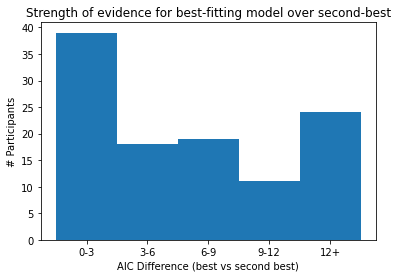

In [46]:
bins=(0,3,6,9,12,15)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_strengths, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(1.5,15,3))
ax.set_xticklabels(("0-3", "3-6", "6-9", "9-12", "12+"))
ax.set_xlabel("AIC Difference (best vs second best)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over second-best")
fig.savefig("../../figures/evidence_strength_best_second.pdf", bbox_inches="tight")

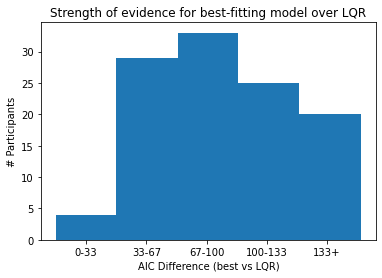

In [24]:
bins=(0,33,67,100,133,167)
fig, ax = plt.subplots()
ax.hist(np.clip(evidence_vs_lqr, bins[0], bins[-1]), bins=bins)
ax.set_xticks(np.arange(16.5,167,33))
ax.set_xticklabels(("0-33", "33-67", "67-100", "100-133", "133+"))
ax.set_xlabel("AIC Difference (best vs LQR)")
ax.set_ylabel("# Participants")
ax.set_title("Strength of evidence for best-fitting model over LQR")
fig.savefig("../../figures/evidence_strength_best_lqr.pdf", bbox_inches="tight")

In [25]:
np.mean(evidence_vs_lqr)

93.32855451171172

In [26]:
len([x for x in evidence_vs_lqr if x <= -16])

0

In [27]:
len([x for x in evidence_strengths if x <= -4])

0

In [28]:
best_fit_pps = {}
for agent_type in ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']:
    best_fit_pps[agent_type] = [pp_id for pp_id in pp_nrs if participant_to_best_model[pp_id] == agent_type]

In [29]:
non_null_agent_types = ['sparse_max_discrete', 'sparse_max_continuous', 'hill_climbing']

## Qualitative Analysis

In [30]:
raw_pp_data_path = '../../data/experimental_data/experiment_actions.csv'
df_pps = pd.read_csv(raw_pp_data_path)

In [31]:
df_last = df_pps.loc[df_pps.groupby("pp_id")['Unnamed: 0'].idxmax()]

Get scores by which model explains each pp best

In [32]:
scores_by_best_model = defaultdict(list)
for index, row in df_last.iterrows():
    scores_by_best_model[participant_to_best_model[row['pp_id']]].append(np.sqrt(row['total_cost']))

In [33]:
for m in scores_by_best_model:
    print(f"{m} median: {np.median(scores_by_best_model[m])}")
    print(f"{m} mean: {np.mean(scores_by_best_model[m])}")
    print(f"m sem: {stats.sem(scores_by_best_model[m])}")

sparse_lqr median: 111.1852508204213
sparse_lqr mean: 127.53367714850977
m sem: 24.064814392026076
sparse_max_continuous median: 129.1218804076211
sparse_max_continuous mean: 208.95597505668053
m sem: 78.43157054799241
sparse_max_discrete median: 74.49206966861313
sparse_max_discrete mean: 96.11524972313592
m sem: 16.90692720000236
null_model_1 median: 143.8314291106085
null_model_1 mean: 221.9106576723773
m sem: 71.18860597700859
hill_climbing median: 149.62633458051428
hill_climbing mean: 357.2649265463586
m sem: 204.4184866962753
null_model_2 median: 173.29091147547237
null_model_2 mean: 8522.847803868244
m sem: 8291.150982037241


In [34]:
np.median(scores_by_best_model['sparse_lqr'])

111.1852508204213

In [35]:
np.median(scores_by_best_model['hill_climbing'])

149.62633458051428

In [36]:
def bootstrap_ci(data, n=1000000):
    all_medians = []
    for i in range(n):
        bs_data = np.random.choice(data, len(data), replace=True)
        med = np.median(bs_data)
        all_medians.append(med)
    all_medians = np.array(all_medians)
    lower_bound = np.percentile(all_medians, 2.5)
    upper_bound = np.percentile(all_medians, 97.5)
    
    return lower_bound, upper_bound

In [37]:
for model_type in ("sparse_lqr", "hill_climbing"):
    scores = scores_by_best_model[model_type]
    lower_bound, upper_bound = bootstrap_ci(scores)
    print(f"{model_type}: {np.median(scores)}, [{lower_bound}, {upper_bound}]")

sparse_lqr: 111.1852508204213, [82.49448466412771, 148.20573538159715]
hill_climbing: 149.62633458051428, [113.60154048251282, 188.81366475973084]


In [38]:
stats.kruskal(scores_by_best_model['sparse_lqr'], scores_by_best_model['hill_climbing'])

KruskalResult(statistic=1.3428061300401737, pvalue=0.24653970716608314)

Get descriptive stats like number of variables manipulated.

In [39]:
print(len(scores_by_best_model['sparse_lqr']) + len(scores_by_best_model['hill_climbing']))

46


Compute the number of variables manipulated and input norm standard deviation for humans.

In [40]:
n_variables_manipulated = []
n_all_zero = 0
norms = []
for index, row in df_pps.iterrows():
    exogenous = literal_eval(row['exogenous_input'])
    n_manipulated = len([x for x in exogenous if x != 0])
    if exogenous == [0., 0., 0., 0.]:
        n_all_zero += 1
    n_variables_manipulated.append(n_manipulated)
    norms.append(sum([x**2 for x in exogenous]))
    
mean_manip = np.mean(n_variables_manipulated)
ci_manip = 1.96 *stats.sem(n_variables_manipulated)
print(f"mean number of variables manipulated: {mean_manip}")
print(f"95% CI number of variables manipulated: {(mean_manip - ci_manip, mean_manip + ci_manip)}")
print(f"median number of variables manipulated: {np.median(n_variables_manipulated)}")
print(f"iqr number of variables manipulated: {stats.iqr(n_variables_manipulated)}")
print(f"number of all zero inputs: {n_all_zero}")
print(f"norm med: {np.median(norms)}")
print(f"norm iqr: {stats.iqr(norms)}")
print(f"norm std: {np.std(norms)}")

mean number of variables manipulated: 2.0631199278629397
95% CI number of variables manipulated: (1.99701877926644, 2.1292210764594395)
median number of variables manipulated: 2.0
iqr number of variables manipulated: 2.0
number of all zero inputs: 56
norm med: 134.0
norm iqr: 759.0
norm std: 3482646.332299877


In [41]:
all_norm_meds = []
all_norm_stds = []
for pp in df_pps['pp_id'].drop_duplicates():
    norms = []
    for index, row in df_pps[df_pps['pp_id'] == pp].iterrows():
        exogenous = literal_eval(row['exogenous_input']) 
        norm = np.sqrt(sum([x**2 for x in exogenous]))
        norms.append(norm)
    # print(f"median norm: {np.median(norms)}")
    # print(f"std norm: {np.std(norms)}")
    all_norm_stds.append(np.std(norms))
    all_norm_meds.append(np.median(norms))

In [42]:
np.median(all_norm_meds)

11.269078289549748

In [43]:
np.median(all_norm_stds)

14.681139904908841